Install chencrafts:
`pip install chencrafts`

In [287]:
import numpy as np
import scqubits as scq
import matplotlib.pyplot as plt
import qutip as qt
import chencrafts as cc

In [506]:
exp_params = {
    'E_Ja': 4.6,
    'E_Jb': 5.5,
    'E_Ca': 0.9,
    'E_Cb': 0.9,
    'E_J': 3,
    'E_C': 50,
    'ECm': 16.686114352392064,
    'E_L1': 2,
    'E_L2': 2,
    # 'E_La': 0.292,
    # 'E_Lb': 0.287,
    'E_La': 0.21,
    'E_Lb': 0.21,

    'flux_s': 0.5 - 0.4483319171817633,
    'flux_c': 0.31710517597502225,
}

para = exp_params
para["flux_a"] = 0.5 + para["flux_s"]
para["flux_b"] = 0.5 - para["flux_s"]

In [507]:
sim_params = {
    "qa_cutoff": 110,
    "qb_cutoff": 110,
    "p_cutoff": 110,
    "m_cutoff": 110,
    "qa_dim": 5,
    "qb_dim": 5,
    "p_dim": 5,
    "m_dim": 7,
}

In [508]:
circ_yaml = f"""
branches:
# qubit a
- ["JJ", 0, 1, E_Ja = {para["E_Ja"]}, E_Ca = {para["E_Ca"]}]
- ["L", 1, 2, E_La = {para["E_La"]}]

# coupler
- ["C", 0, 2, E_C = {para["E_C"]}]
- ["L", 0, 2, E_L1 = {para["E_L1"]}]
- ["C", 0, 3, E_C]
- ["L", 0, 3, E_L2 = {para["E_L2"]}]
- ["JJ", 2, 3, E_J = {para["E_J"]}, ECm = {para["ECm"]}]

# qubit b
- ["JJ", 0, 4, E_Jb = {para["E_Jb"]}, E_Cb = {para["E_Cb"]}]
- ["L", 3, 4, E_Lb = {para["E_Lb"]}]
"""

ftc = scq.Circuit(circ_yaml, from_file=False)

trans_mat = np.linalg.inv([
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 1, -1, 0],
    [0, 1, 1, 0],
])

brch = ftc.branches
ftc.configure(
    transformation_matrix=trans_mat, 
    system_hierarchy=[[1], [2], [[3], [4]]], 
    subsystem_trunc_dims=[
        sim_params["qa_dim"], 
        sim_params["qb_dim"],
        [sim_params["m_dim"] * 2, [
            sim_params["m_dim"], 
            sim_params["p_dim"]
        ]], 
    ],
    closure_branches=[
        brch[0], brch[7], brch[6]   # flux in junctions
    ],
    # closure_branches=[circ.branches[1], circ.branches[4]]   # flux in inductors
)
ftc.cutoff_ext_1 = sim_params["qa_cutoff"]
ftc.cutoff_ext_2 = sim_params["qb_cutoff"]
ftc.cutoff_ext_3 = sim_params["m_cutoff"]
ftc.cutoff_ext_4 = sim_params["p_cutoff"]

ftc.Φ1 = para["flux_a"]
ftc.Φ2 = para["flux_b"]
ftc.Φ3 = -para["flux_c"]

ftc.sym_hamiltonian()

<IPython.core.display.Latex object>

In [509]:
Ecp = 100
C = 2*cc.tb.C_by_EC(Ecp)
Ec = cc.tb.EC_by_C(C)
Cc = cc.tb.C_by_EC(14.3)-cc.tb.C_by_EC(Ecp)
Ecc = cc.tb.EC_by_C(Cc)

In [510]:
print(Ec,Ecc)

50.0 16.686114352392064


In [511]:
cc.tb.EC_by_C(9.6)

2.017732221318659

In [512]:
evals = ftc.eigenvals(4)
evals - evals[0]

array([0.      , 0.260634, 0.261994, 0.502685])

## Sweet spot identification

In [513]:
from typing import Tuple

def find_sweetspot_by_spectrum(
    self,   # the ftc circuit
    flux_c = None, 
    evals_count=4,
    ftol = 1e-8,
    gtol = 1e-8,
    eps = 1e-11,
    mode = "l3",
    flux_s_bounds = [0, 0.1],
    flux_sb_bounds = None,      # if not None, flux_a and b are independent
    flux_c_bounds = [0.25, 0.3],
    run_num = 1,
    **kwargs
) -> Tuple[float, float, float]:
    
    def freq_ab(params, evals_count, mode):
        try:
            self.flux_a = 0.5 + params["flux_s"]
            self.flux_c = params["flux_c"]
            if flux_sb_bounds is None:
                self.flux_b = 0.5 - params["flux_s"]
            else:
                self.flux_b = 0.5 + params["flux_sb"]
        except Exception:
            self.Φ1 = 0.5 + params["flux_s"]
            if flux_sb_bounds is None:
                self.Φ2 = 0.5 - params["flux_s"]
            else:
                self.Φ2 = 0.5 + params["flux_sb"]
            self.Φ3 = params["flux_c"]

        eigs = self.eigenvals(evals_count)
        if mode == "l3":
            return eigs[3] - eigs[0]
        elif mode == "l1+l2":
            return eigs[1] + eigs[2] - 2 * eigs[0]
        elif mode == "l2-l1":
            return np.abs(eigs[2] - eigs[1])
        elif mode == "zz":
            abszz = np.abs(eigs[3] - eigs[2] - eigs[1] + eigs[0])
            return abszz
        elif mode == "l1+l2+zz":
            abszz = np.abs(eigs[3] - eigs[2] - eigs[1] + eigs[0])
            return eigs[1] + eigs[2] - 2 * eigs[0] + abszz
        else:
            raise ValueError("mode not supported")
        
    free_params = {"flux_s": flux_s_bounds, "flux_c": flux_c_bounds}
    if flux_sb_bounds is not None:
        free_params["flux_sb"] = flux_sb_bounds
    
    opt = cc.tb.Optimization(
        {}, free_params,
        freq_ab,
        optimizer="L-BFGS-B",
        target_kwargs={"evals_count": evals_count, "mode": mode},
        opt_options={"ftol": ftol, "gtol": gtol, "disp": False, "eps": eps, "maxls": 100}
    )

    if flux_c is not None:
        opt.fix(flux_c=flux_c)
    
    multi_opt = cc.tb.MultiOpt(opt)
    multi_traj = multi_opt.run(run_num)
    traj = multi_traj.best_traj()

    try:
        self.flux_a = 0.5 + traj.final_full_para["flux_s"]
        self.flux_c = traj.final_full_para["flux_c"]
        if flux_sb_bounds is None:
            self.flux_b = 0.5 - traj.final_full_para["flux_s"]
        else:
            self.flux_b = 0.5 + traj.final_full_para["flux_sb"]
        
        return self.flux_a, self.flux_b, self.flux_c
    except Exception:
        self.Φ1 = 0.5 + traj.final_full_para["flux_s"]
        if flux_sb_bounds is None:
            self.Φ2 = 0.5 - traj.final_full_para["flux_s"]
        else:
            self.Φ2 = 0.5 + traj.final_full_para["flux_sb"]
        self.Φ3 = traj.final_full_para["flux_c"]
        
        return self.Φ1, self.Φ2, self.Φ3


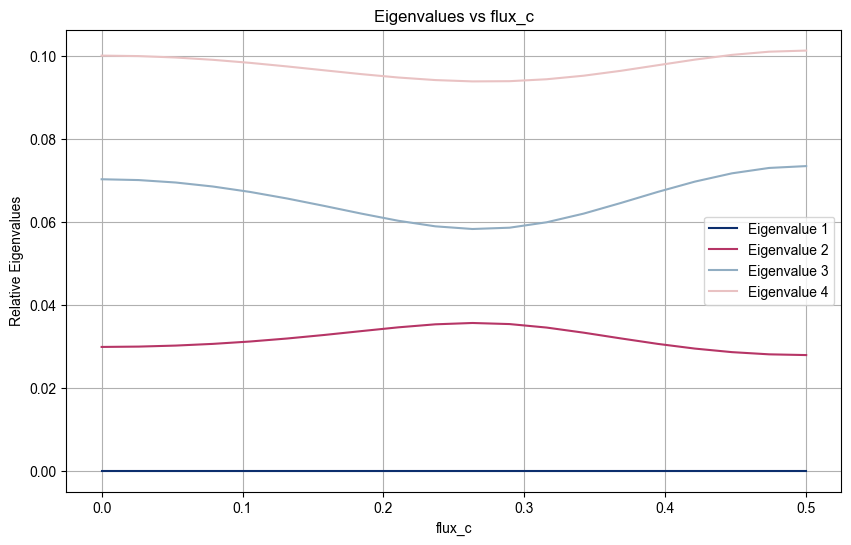

In [514]:
flux_c_values = np.linspace(0, 0.5, 20)  # Create 100 points between 0 and 0.5
evals_array = []

for flux_c in flux_c_values:
    phi1, phi2, phi3 = find_sweetspot_by_spectrum(
        ftc, 
        flux_c=flux_c,
        flux_s_bounds=[-0.1, 0.1],
        run_num=1,
    )
    evals = ftc.eigenvals(4)
    evals_relative = evals - evals[0]
    evals_array.append(evals_relative)

evals_array = np.array(evals_array)

# Plotting
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.plot(flux_c_values, evals_array[:, i], label=f'Eigenvalue {i+1}')

plt.xlabel('flux_c')
plt.ylabel('Relative Eigenvalues')
plt.title('Eigenvalues vs flux_c')
plt.legend()
plt.grid(True)
plt.show()

In [520]:
phi1, phi2, phi3 = find_sweetspot_by_spectrum(
    ftc, 
    flux_c = 0.,
    flux_s_bounds = [-0.1, 0.1],
    # flux_c_bounds = [0.0, 0.5],
    run_num=1,
)
on = [phi1, phi2, phi3]
print(phi1, phi2, phi3)
evals = ftc.eigenvals(4)
evals - evals[0]


0.4999969295826865 0.5000030704173135 0.0


array([0.      , 0.029809, 0.070236, 0.100045])

In [521]:
# phi1, phi2, phi3 = find_sweetspot_by_spectrum(
#     ftc, 
#     # flux_c = 0.4,
#     flux_s_bounds = [-0.1, 0.1],
#     flux_c_bounds = [0.0, 0.5],
#     run_num=1,
# )
# print(phi1, phi2, phi3)
# off = [phi1, phi2, phi3]
# evals = ftc.eigenvals(4)
# evals - evals[0]
ftc.Φ1,ftc.Φ2,ftc.Φ3 = 0.4823993253847567,0.5176006746152433,0.27578709780859395

## Drive & eff coupling

In [522]:
hspace = ftc.hilbert_space
dims = hspace.subsystem_dims
hamiltonian = qt.Qobj(ftc.hamiltonian(), dims=[dims, dims])

theta1_op = qt.Qobj(ftc.θ1_operator(), dims=[dims, dims])
theta2_op = qt.Qobj(ftc.θ2_operator(), dims=[dims, dims])
theta3_op = qt.Qobj(ftc.θ3_operator(), dims=[dims, dims])
theta4_op = qt.Qobj(ftc.θ4_operator(), dims=[dims, dims])
drive_c = (
    (ftc.E_La + ftc.E_Lb) / 2 * (theta1_op - theta2_op) / 2
    - (ftc.E_L1 + ftc.E_L2 + ftc.E_La + ftc.E_Lb) / 4 * theta3_op
)
drive_a = (ftc.E_La + ftc.E_Lb)/2 / 2* (-2*theta1_op+theta3_op+theta4_op)
drive_b = (ftc.E_La + ftc.E_Lb)/2 / 2* (-2*theta2_op-theta3_op+theta4_op)

# Q2_op = qt.Qobj(ftc.Q2_operator(), dims=[dims, dims])
# drive_op = Q2_op

In [523]:

flux_shiftc = -(on[2]-off[2])
flux_shift_a = on[0]-off[0]
flux_shift_b = on[1] - off[1]
hamiltonian1 = hamiltonian + (flux_shift_a*drive_a + flux_shift_b*drive_b + flux_shiftc*drive_c)*2*np.pi
evals, evecs = hamiltonian1.eigenstates(hspace.dimension, tol=1e-10)
evals-evals[0]

array([0.000000e+00, 2.981679e-02, 7.024647e-02, 1.000632e-01, 4.401862e+00, 4.437609e+00, 5.026176e+00, 5.084651e+00,
       5.174315e+00, 5.210073e+00, 5.610975e+00, 5.669449e+00, 7.204187e+00, 7.209571e+00, 7.296277e+00, 7.311743e+00,
       9.425658e+00, 1.000887e+01, 1.019863e+01, 1.078183e+01, 1.162655e+01, 1.225694e+01, 1.231114e+01, 1.232190e+01,
       1.240305e+01, 1.249200e+01, 1.250273e+01, 1.284542e+01, 1.455716e+01, 1.675602e+01, 1.678979e+01, 1.737508e+01,
       1.743049e+01, 1.752462e+01, 1.755991e+01, 1.796775e+01, 1.802208e+01, 1.904636e+01, 1.916835e+01, 1.947677e+01,
       1.954789e+01, 2.178285e+01, 2.196910e+01, 2.198104e+01, 2.214210e+01, 2.215588e+01, 2.233634e+01, 2.256310e+01,
       2.311545e+01, 2.358734e+01, 2.431527e+01, 2.442630e+01, 2.498053e+01, 2.581272e+01, 2.639372e+01, 2.642849e+01,
       2.701223e+01, 2.706957e+01, 2.716455e+01, 2.719984e+01, 2.759740e+01, 2.765418e+01, 2.922291e+01, 2.927755e+01,
       2.958013e+01, 2.967424e+01, 2.974143e+01,

In [524]:

evals, evecs = hamiltonian.eigenstates(hspace.dimension, tol=1e-10)

subspace_state_idx = [0, 1, 2, 3]
subspace1_evecs = [evecs[idx] for idx in subspace_state_idx]
subspace2_evecs = [evec for idx, evec in enumerate(evecs) if idx not in subspace_state_idx]

H_sw, _, _ = cc.cqed.block_diagonalize_pymablock(
    [hamiltonian, (flux_shift_a*drive_a + flux_shift_b*drive_b + flux_shiftc*drive_c)*2*np.pi],     
    # flux drive amp
    subspace_eigenvectors=[subspace1_evecs, subspace2_evecs],
    atol=1e-10,
)


 /Users/apple/miniconda3/envs/flux/lib/python3.12/site-packages/pymablock/block_diagonalization.py: 1091

In [525]:
H_eff = 0
for i in range(100):
    if np.linalg.norm(H_sw[0,0,i])<1e-8:
        break
    H_eff += H_sw[0,0,i]
    

In [527]:
np.abs(H_eff[1,2])

0.017680117760159743

In [528]:
phi1, phi2, phi3 = find_sweetspot_by_spectrum(
    ftc, 
    flux_c = 0.35,
    flux_s_bounds = [-0.1, 0.1],
    # flux_c_bounds = [0.0, 0.5],
    run_num=1,
)
on = [phi1, phi2, phi3]
print(phi1, phi2, phi3)
evals = ftc.eigenvals(4)
evals - evals[0]

ftc.Φ1,ftc.Φ2,ftc.Φ3 = 0.4481395706587772,0.5518604293412228,0.3169069290007238

flux_shiftc = -(on[2]-off[2])
flux_shift_a = on[0]-off[0]
flux_shift_b = on[1] - off[1]

hspace = ftc.hilbert_space
dims = hspace.subsystem_dims
hamiltonian = qt.Qobj(ftc.hamiltonian(), dims=[dims, dims])

theta1_op = qt.Qobj(ftc.θ1_operator(), dims=[dims, dims])
theta2_op = qt.Qobj(ftc.θ2_operator(), dims=[dims, dims])
theta3_op = qt.Qobj(ftc.θ3_operator(), dims=[dims, dims])
theta4_op = qt.Qobj(ftc.θ4_operator(), dims=[dims, dims])
drive_c = (
    (ftc.E_La + ftc.E_Lb) / 2 * (theta1_op - theta2_op) / 2
    - (ftc.E_L1 + ftc.E_L2 + ftc.E_La + ftc.E_Lb) / 4 * theta3_op
)
drive_a = (ftc.E_La + ftc.E_Lb)/2 / 2* (-2*theta1_op+theta3_op+theta4_op)
drive_b = (ftc.E_La + ftc.E_Lb)/2 / 2* (-2*theta2_op-theta3_op+theta4_op)


evals, evecs = hamiltonian.eigenstates(hspace.dimension, tol=1e-10)

subspace_state_idx = [0, 1, 2, 3]
subspace1_evecs = [evecs[idx] for idx in subspace_state_idx]
subspace2_evecs = [evec for idx, evec in enumerate(evecs) if idx not in subspace_state_idx]

H_sw, _, _ = cc.cqed.block_diagonalize_pymablock(
    [hamiltonian, (flux_shift_a*drive_a + flux_shift_b*drive_b + flux_shiftc*drive_c)*2*np.pi],     
    # flux drive amp
    subspace_eigenvectors=[subspace1_evecs, subspace2_evecs],
    atol=1e-10,
)

H_eff = 0
for i in range(100):
    if np.linalg.norm(H_sw[0,0,i])<1e-8:
        break
    H_eff += H_sw[0,0,i]
    
print(np.abs(H_eff[0,3]))

0.48491588041516187 0.5150841195848381 0.35


KeyboardInterrupt: 

In [547]:

from joblib import Parallel, delayed


def calculate_H_eff(flux_c):
    phi1, phi2, phi3 = find_sweetspot_by_spectrum(
        ftc, 
        flux_c=flux_c,
        flux_s_bounds=[-0.1, 0.1],
        run_num=1,
    )
    on = [phi1, phi2, phi3]
    
    evals = ftc.eigenvals(4)
    evals - evals[0]
    off = [0.4823993253847567,0.5176006746152433,0.27578709780859395]
    ftc.Φ1, ftc.Φ2, ftc.Φ3 = off

    flux_shiftc = -(on[2]-off[2])
    flux_shift_a = on[0]-off[0]
    flux_shift_b = on[1] - off[1]

    hspace = ftc.hilbert_space
    dims = hspace.subsystem_dims
    hamiltonian = qt.Qobj(ftc.hamiltonian(), dims=[dims, dims])

    theta1_op = qt.Qobj(ftc.θ1_operator(), dims=[dims, dims])
    theta2_op = qt.Qobj(ftc.θ2_operator(), dims=[dims, dims])
    theta3_op = qt.Qobj(ftc.θ3_operator(), dims=[dims, dims])
    theta4_op = qt.Qobj(ftc.θ4_operator(), dims=[dims, dims])
    drive_c = (
        (ftc.E_La + ftc.E_Lb) / 2 * (theta1_op - theta2_op) / 2
        - (ftc.E_L1 + ftc.E_L2 + ftc.E_La + ftc.E_Lb) / 4 * theta3_op
    )
    drive_a = (ftc.E_La + ftc.E_Lb)/2 / 2* (-2*theta1_op+theta3_op+theta4_op)
    drive_b = (ftc.E_La + ftc.E_Lb)/2 / 2* (-2*theta2_op-theta3_op+theta4_op)

    evals, evecs = hamiltonian.eigenstates(hspace.dimension, tol=1e-10)

    subspace_state_idx = [0, 1, 2, 3]
    subspace1_evecs = [evecs[idx] for idx in subspace_state_idx]
    subspace2_evecs = [evec for idx, evec in enumerate(evecs) if idx not in subspace_state_idx]

    H_sw, _, _ = cc.cqed.block_diagonalize_pymablock(
        [hamiltonian, (flux_shift_a*drive_a + flux_shift_b*drive_b + flux_shiftc*drive_c)*2*np.pi],     
        subspace_eigenvectors=[subspace1_evecs, subspace2_evecs],
        atol=1e-10,
    )

    H_eff = 0
    for i in range(100):
        if np.linalg.norm(H_sw[0,0,i])<1e-8:
            break
        H_eff += H_sw[0,0,i]
    evals = np.linalg.eigh(H_eff)[0]
    return np.abs(H_eff[1,2]),(evals-evals[0])

# Generate 20 flux_c values between 0.2 and 0.4
flux_c_values = np.linspace(0., 0.5, 6)

# Use joblib to parallelize the computation
results = Parallel(n_jobs=1)(delayed(calculate_H_eff)(flux_c) for flux_c in flux_c_values)



 /Users/apple/miniconda3/envs/flux/lib/python3.12/site-packages/pymablock/block_diagonalization.py: 1091

In [553]:
results

[(0.017680150198956024, array([0.      , 0.029817, 0.070246, 0.100063])),
 (0.015245122670769218, array([0.      , 0.030993, 0.067474, 0.098467])),
 (0.00805707986588077, array([0.      , 0.034182, 0.060894, 0.095075])),
 (0.0028437212817444273, array([0.      , 0.035048, 0.058966, 0.094014])),
 (0.01384148563189359, array([0.      , 0.030297, 0.067719, 0.098016])),
 (0.01870214698403364, array([0.      , 0.027852, 0.073428, 0.10128 ]))]

In [554]:
evals_array

array([[0.      , 0.029809, 0.070236, 0.100045],
       [0.      , 0.029891, 0.070038, 0.099929],
       [0.      , 0.030137, 0.069449, 0.099585],
       [0.      , 0.030546, 0.068486, 0.099032],
       [0.      , 0.031117, 0.067183, 0.0983  ],
       [0.      , 0.031839, 0.065597, 0.097436],
       [0.      , 0.032692, 0.063813, 0.096505],
       [0.      , 0.033623, 0.061961, 0.095584],
       [0.      , 0.034536, 0.06023 , 0.094765],
       [0.      , 0.035263, 0.058885, 0.094147],
       [0.      , 0.035584, 0.058243, 0.093826],
       [0.      , 0.035322, 0.058556, 0.093878],
       [0.      , 0.034481, 0.059861, 0.094342],
       [0.      , 0.033248, 0.061954, 0.095202],
       [0.      , 0.031867, 0.064512, 0.096379],
       [0.      , 0.030541, 0.067191, 0.097732],
       [0.      , 0.029409, 0.06967 , 0.099079],
       [0.      , 0.028555, 0.071668, 0.100223],
       [0.      , 0.028026, 0.072962, 0.100988],
       [0.      , 0.027847, 0.073409, 0.101257]])

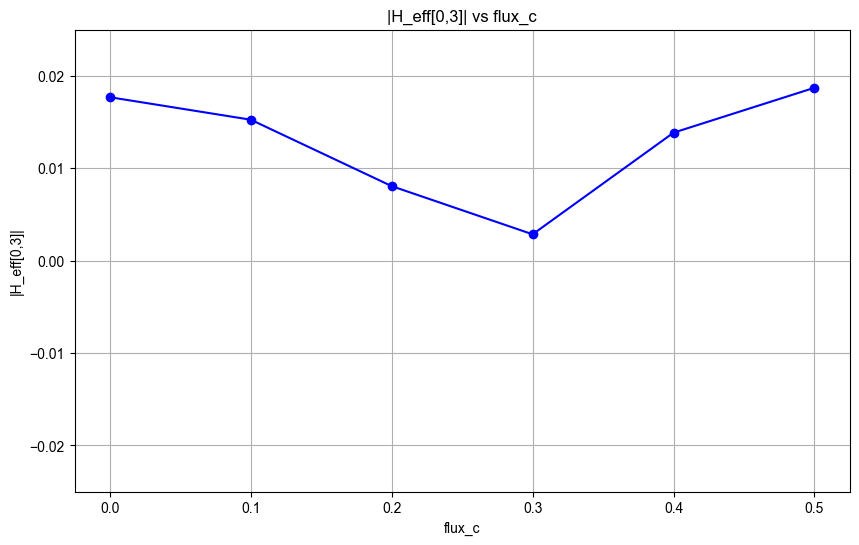

In [545]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(flux_c_values, results, 'b-o')
plt.xlabel('flux_c')
plt.ylabel('|H_eff[0,3]|')
plt.title('|H_eff[0,3]| vs flux_c')
plt.ylim(-0.025,0.025)
plt.grid(True)
plt.show()

In [546]:
results

[0.01768017989145324, 0.015245134153573738, 0.00805710878592466, 0.0028436454779514958, 0.013841492172637915, 0.01870215003194353]